In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import optimizers
from keras.preprocessing import image

In [3]:
img_dims = 256
batch_size = 32

In [4]:
input_path = '/content/drive/MyDrive/Corn Leaves/'
def process_data(img_dims, batch_size):
    train_datagen = image.ImageDataGenerator(
        rescale = 1./255,
        rotation_range = 40,
        zoom_range = 0.2,
        height_shift_range = 0.3,
        width_shift_range = 0.3,
        horizontal_flip = True
    )
    
    test_datagen = image.ImageDataGenerator(rescale = 1./255)
    
    train_generator = train_datagen.flow_from_directory(
        directory = input_path + 'train',
        target_size = (img_dims, img_dims),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = True
    )
    
    test_generator = test_datagen.flow_from_directory(
        directory = input_path + 'test',
        target_size = (img_dims, img_dims),
        batch_size = batch_size,
        class_mode = 'categorical',
        shuffle = False
    )
    return train_generator, test_generator

In [5]:
train_data, test_data = process_data(img_dims, batch_size)

Found 3419 images belonging to 4 classes.
Found 421 images belonging to 4 classes.


In [6]:
from keras.applications import Xception

def dense_block(units, dropout_rate, inputs):
  x = keras.layers.Dense(units, activation="relu")(inputs)
  x = keras.layers.BatchNormalization()(x)
  outputs = keras.layers.Dropout(dropout_rate)(x)
  return outputs


In [7]:
def build_model():
  inputs = keras.layers.Input(shape = (img_dims, img_dims, 3))
  model = Xception(input_tensor= inputs,
                   weights = 'imagenet',
                   include_top = True)
  last_layer = model.get_layer('block14_sepconv2_act').output
  x = keras.layers.Flatten()(last_layer)
  x = dense_block(128, 0.5, x)
  outputs = keras.layers.Dense(4, activation = "softmax")(x)
  model = keras.models.Model(inputs = inputs, outputs = outputs)
  return model

In [8]:
model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________________________________________

In [9]:
for layer in model.layers[:-4]:
  layer.trainable = False

In [10]:
optimizer = keras.optimizers.RMSprop(learning_rate= 0.001, momentum = 0.6)
model.compile(loss = "categorical_crossentropy",
              optimizer = optimizer,
              metrics = ['accuracy'])
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.2,
                                              patience = 2,
                                              mode = 'min')
callbacks = [reduce_lr]

In [11]:
hist = model.fit(
    train_data,epochs = 10,
    validation_data = test_data,
    callbacks = callbacks

)

Epoch 1/10
107/107 [==============================] - 992s 9s/step - loss: 0.6532 - accuracy: 0.7906 - val_loss: 0.3482 - val_accuracy: 0.8646
Epoch 2/10
107/107 [==============================] - 989s 9s/step - loss: 0.3021 - accuracy: 0.8898 - val_loss: 0.2748 - val_accuracy: 0.8789
Epoch 3/10
107/107 [==============================] - 992s 9s/step - loss: 0.2768 - accuracy: 0.8994 - val_loss: 0.3478 - val_accuracy: 0.8670
Epoch 4/10
107/107 [==============================] - 993s 9s/step - loss: 0.2129 - accuracy: 0.9193 - val_loss: 0.2269 - val_accuracy: 0.9050
Epoch 5/10
107/107 [==============================] - 991s 9s/step - loss: 0.2087 - accuracy: 0.9181 - val_loss: 0.2971 - val_accuracy: 0.8765
Epoch 6/10
107/107 [==============================] - 993s 9s/step - loss: 0.2098 - accuracy: 0.9234 - val_loss: 0.2452 - val_accuracy: 0.8979
Epoch 7/10
107/107 [==============================] - 995s 9s/step - loss: 0.2012 - accuracy: 0.9220 - val_loss: 0.1819 - val_accuracy: 0.9074

In [12]:
scores = model.evaluate(test_data, verbose = 1)
print("Loss: ", scores[0])
print("Accuracy: ", scores[1])

14/14 [==============================] - 103s 7s/step - loss: 0.1888 - accuracy: 0.9169
Loss:  0.18876641988754272
Accuracy:  0.9168646335601807


In [13]:
model.save('CornLeafDiseaseXceptionTPU.h5')

In [14]:
from sklearn.metrics import confusion_matrix,classification_report

In [15]:
pred = model.predict(test_data, verbose=1)
y_pred = np.argmax(pred, axis = 1)
y_pred

14/14 [==============================] - 106s 7s/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 3, 3,
       3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 3, 1, 1, 1, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 3,
       3, 1, 1, 1, 1, 1, 3, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 3, 1, 3, 1,
       3, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [18]:
class_labels = test_data.class_indices
class_labels = {v:k for k, v in class_labels.items()}
classes = list(class_labels.values())
classes

['Common_rust', 'Gray_leaf_spot', 'Healthy', 'Northern_Leaf_Blight']

In [19]:
print("Confusion Matrix")
print(confusion_matrix(test_data.classes, y_pred))

Confusion Matrix
[[105   0   0   0]
 [  0  80   0  25]
 [  0   0 106   0]
 [  2   8   0  95]]


In [20]:
print('Classification Report')
print(classification_report(test_data.classes, y_pred, target_names = classes))

Classification Report
                      precision    recall  f1-score   support

         Common_rust       0.98      1.00      0.99       105
      Gray_leaf_spot       0.91      0.76      0.83       105
             Healthy       1.00      1.00      1.00       106
Northern_Leaf_Blight       0.79      0.90      0.84       105

            accuracy                           0.92       421
           macro avg       0.92      0.92      0.92       421
        weighted avg       0.92      0.92      0.92       421



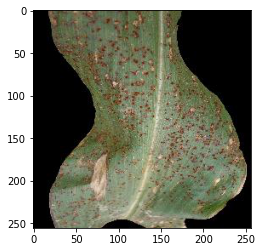

In [23]:
img = keras.preprocessing.image.load_img('/content/drive/MyDrive/Corn Leaves/test/Common_rust/RS_Rust 2745.JPG',
                                         target_size = (img_dims, img_dims))
plt.imshow(img)

In [24]:
img = keras.preprocessing.image.img_to_array(img)
x = img/255
x = np.expand_dims(x, axis=0)
print(x.shape)

(1, 256, 256, 3)


In [28]:
CLASS_NAMES = {
    'classes' :['Common rust', 'Gray leaf spot', 'Healthy', 'Northern Leaf Blight']
    }
prediction = model.predict(x)
predicted_c = np.argmax(prediction, axis=1)
predicted_c
predicted_class = CLASS_NAMES['classes'][predicted_c[0]]
print("This image is of :",predicted_class.lower())

This image is of : common rust


This image is of : gray leaf spot


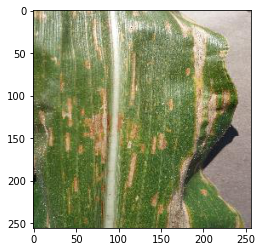

In [31]:
img = keras.preprocessing.image.load_img('/content/drive/MyDrive/Corn Leaves/test/Gray_leaf_spot/de66a37b-002d-4e21-8f4a-a34976b74892___RS_GLSp 9283.JPG',
                                         target_size = (256, 256))
plt.imshow(img)
img = keras.preprocessing.image.img_to_array(img)
x = img/255
x = np.expand_dims(x, axis=0)
prediction = model.predict(x)
predicted_c = np.argmax(prediction, axis=1)
predicted_c
predicted_class = CLASS_NAMES['classes'][predicted_c[0]]
print("This image is of :",predicted_class.lower())


This image is of : healthy


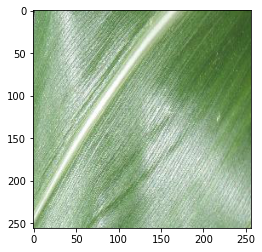

In [32]:
img = keras.preprocessing.image.load_img('/content/drive/MyDrive/Corn Leaves/test/Healthy/f268527f-b057-44aa-b455-b62612469032___R.S_HL 5506 copy 2.jpg',
                                         target_size = (img_dims, img_dims))
plt.imshow(img)
img = keras.preprocessing.image.img_to_array(img)
x = img/255
x = np.expand_dims(x, axis=0)
prediction = model.predict(x)
predicted_c = np.argmax(prediction, axis=1)
predicted_c
predicted_class = CLASS_NAMES['classes'][predicted_c[0]]
print("This image is of :",predicted_class.lower())

This image is of : northern leaf blight


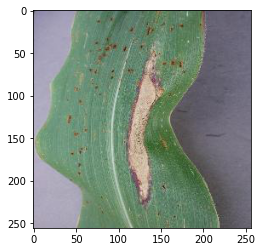

In [33]:
img = keras.preprocessing.image.load_img('/content/drive/MyDrive/Corn Leaves/test/Northern_Leaf_Blight/fa30c8e9-b74d-49a2-8611-c9b9098e21c3___RS_NLB 3507.JPG',
                                         target_size = (img_dims, img_dims))
plt.imshow(img)
img = keras.preprocessing.image.img_to_array(img)
x = img/255
x = np.expand_dims(x, axis=0)
prediction = model.predict(x)
predicted_c = np.argmax(prediction, axis=1)
predicted_c
predicted_class = CLASS_NAMES['classes'][predicted_c[0]]
print("This image is of :",predicted_class.lower())